## Introduction

In addition to directly solving optimization, quadratic unconstrained binary optimization solvers like ours have machine learning applications. The specific application we demonstrate here is one known as boosting. Particularly we are demonstrating a variant of boosting that has been adapted to quadratic solvers known as QBoost. The underlying idea of boosting is to use many sources of imperfect information to build a strong prediction. In machine learning language, we find a collection of weak classifiers that together can form a strong classifier. A weighted combination of these sources of partial information can provide a powerful tool if combined in the right way. The task that the Dirac device will be doing is to find this combination. An obvious constraint is to include the classifiers that give the most accurate information, but there is another concern. We want ones that give complementary information. Statistically speaking, we want to take classifiers that have high correlations with the information that we want to classify, but have weak correlations between them. In the extreme case, two classifiers could give the exact same information, in which case including both is wasteful. However, avoiding waste isn't the only concern here. Including too many classifiers can also lead to overfitting if they capture spurious information specific to the training data, rather than information that will generalize well to unseen cases. In this tutorial, we show an implementation of QBoost and test it on a simple binary classification problem using the IRIS dataset.

## Importance

An advantage of boosting is that once the strong classifier is built, it can be applied without having to re-solve the QUBO. As a result, the classifier can be applied in settings where access to Dirac is not available. As Dirac only gets used in the training phase, it also can be reused many times in the future. This simple application provides one example of many potential machine learning applications of our hardware.



## Application

Classification, the task that QBoost performs, appears in a number of settings. A simple example of a classification problem that you are probably impacted by every day is email spam filtering. Here, the goal is to categorize email as "spam" or "legitimate", and it is relatively straightforward to see how the boosting approach can be applied. A variety of weak rules can be derived, (for example, a spam email is probably slightly more likely to contain the word "money"). These are of little use individually, but can be made into a powerful filter when combined through boosting. Disease diagnosis is also fundamentally a classification problem with a concrete example being the use of boosting to predict chronic kidney disease. The weak classifiers would come from patient medical history, such as whether they have other conditions or not, as well as other factors such as age. Also, boosting approaches can be applied to image recognition. This is done by using simple features (for example, a nose between two eyes represented by a lighter rectangle between two darker ones) as weak classifiers, and checking for combinations of them, as was done here for facial recognition.

## Methodology

# Methodology

The idea is based on the concept of boosting. Let us assume that we have a collection of $N$ *weak* classifiers $h_i$ where $i = 1, 2, \ldots, N$. The goal is to construct a *strong* classifier as a linear superposition of these weak classifiers, that is:

$$
y = \sum_{i=1}^N w_i \, h_i(x)
$$

where $x$ is a vector of input features and $y \in \{-1, 1\}$. The goal is to find $\{w_i\}$, the weights associated with the weak classifiers.

Let us have a training set $\{(x_s, y_s) \mid s = 1, 2, \ldots, S\}$ of size $S$. We can determine optimal weights $w_i$ by minimizing:

$$
\min_w \sum_{s=1}^S \Biggl[\sum_{i=1}^N w_i \, h_i(x_s) - y_s\Biggr]^2
\;+\; \lambda \sum_{i=1}^N (w_i)^0
$$

where the regularization term $\lambda \sum_{i=1}^N (w_i)^0$ penalizes non-zero weights; $\lambda$ is the regularization coefficient. Re-arranging the above equation yields,

$$
\min_w \;
\frac{1}{N} \sum_{i=1}^N \sum_{j=1}^N w_i \, w_j \sum_{s=1}^S h_i(x_s)\,h_j(x_s)
\;-\; \frac{2}{N}\sum_{i=1}^N \sum_{s=1}^S y_s \, h_i(x_s) \, w_i
\;+\; \lambda \sum_{i=1}^N (w_i)^0
$$

where we assume that each weight $w_i$ is an integer. Each weight can be constructed using $D$ qubits as

$$
w_i
= \sum_{d=0}^{D-1} 2^d\,x_{i,d}
$$

where $x_{i,d}$ are binary variables. Navin et al. ([arXiv:0811.0416](https://arxiv.org/abs/0811.0416)) reported that using $D = 1$ yields similar or improved generalized errors compared to $D > 1$. The regularization term $\lambda \sum_{i=1}^N (w_i)^0$ only works when $D = 1$, that is, when the weights are binary. The corresponding QUBO is then

$$
\min_x \; x^T (Q + P)\, x
$$

where

$$
Q_{ij} = \frac{1}{N} \sum_{s=1}^S h_i(x_s)\,h_j(x_s)
$$

and

$$
P_{ij}
= \delta_{ij} \Bigl(\lambda
  - \frac{2}{N} \sum_{s=1}^S h_i(x_s)\,y_s \Bigr).
$$

Note that the regularization term is designed to push many weights to zero, so only a subset of the weak classifiers is chosen. In the implementation that follows, we have used decision tree classifiers based on one, two, or three of the features as the weak classifiers.


## Installation of `qci-client`

In [ ]:
! pip install --upgrade "qci-client<5"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.6 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nx-cugraph-cu12 24.10.0 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
scikit-image 0.25.0 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.


## Implementation QBoost Algorithm

We have implemented the QBoost algorithm that was explained above as a class in Python.



In [ ]:
from qci_client import QciClient
token = "xxx"
api_url = "https://api.qci-prod.com"
qci = QciClient(api_token=token, url=api_url)

In [ ]:
# Import libs
import os
import sys
import time
import datetime
import json
from functools import wraps
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
)


PLOT_FLAG = False


def timer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        beg_time = time.time()
        val = func(*args, **kwargs)
        end_time = time.time()
        tot_time = end_time - beg_time

        print("Runtime of %s: %0.2f seconds!" % (func.__name__, tot_time,))

        return val

    return wrapper


from typing import List
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


class WeakClassifierMLP:
    """
    A simple wrapper that uses a TensorFlow model on a chosen subset of features.
    """

    def __init__(self, fea_ind_list: List[int], X_train: np.ndarray, y_train: np.ndarray) -> None:
        """
        Initialize the weak classifier.

        Parameters
        ----------
        fea_ind_list : List[int]
            Indices of features to use for this classifier.
        X_train : np.ndarray
            Training data of shape (num_samples, num_features).
        y_train : np.ndarray
            Training labels of shape (num_samples,).
        """
        # Validate the shapes
        assert X_train.shape[0] == len(y_train), \
            "X_train and y_train must have the same number of samples."

        self.fea_ind_list = fea_ind_list
        self.X_train = X_train
        self.y_train = y_train

        # Create a small TensorFlow model with 3 Dense layers to act as our "weak" learner.
        # Adjust hidden layer sizes, activations, or optimizer settings as needed.
        self.model = Sequential([
            Dense(8, activation='relu'),   # First hidden layer
            Dense(8, activation='relu'),   # Second hidden layer
            Dense(1, activation='sigmoid') # Final output layer for binary classification
        ])

        self.model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

    def train(self) -> None:
        """
        Fit the TensorFlow model on the subset of features.
        """
        # Slice X_train to keep only the chosen features
        X_subset = self.X_train[:, self.fea_ind_list]

        # Fit the classifier. For brevity, we use fewer epochs. Adjust as needed.
        self.model.fit(
            X_subset,
            self.y_train,
            epochs=10,       # Lower epoch count to keep it "weak"
            batch_size=32,
            verbose=0        # Suppress training output
        )

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict labels (+1/-1) for the given samples X.

        Parameters
        ----------
        X : np.ndarray
            Input data of shape (num_samples, num_features).

        Returns
        -------
        np.ndarray
            Array of predictions (+1 or -1) for each sample.
        """
        # Keep only the chosen features
        X_subset = X[:, self.fea_ind_list]

        # Model outputs probabilities in [0, 1].
        probs = self.model.predict(X_subset)

        # Convert to {0,1} by thresholding at 0.5
        raw_preds = (probs >= 0.5).astype(int).flatten()

        # Convert predictions to {-1, +1} if necessary
        unique_labels = np.unique(self.y_train)
        if set(unique_labels) == {0, 1}:
            # Convert 0 -> -1
            converted_preds = np.where(raw_preds == 0, -1, 1)
        else:
            # If already in {-1, +1}, no conversion needed
            converted_preds = raw_preds

        return converted_preds


class QBoost:
    def __init__(
        self,
        lambda_coef,
        num_eqc_samples=10,
        alpha=1.0,
        theta=0.0,
        mode="dct",
    ):

        self.lambda_coef = lambda_coef
        self.num_eqc_samples = num_eqc_samples
        self.alpha = alpha
        self.theta = theta
        self.mode = mode
        self.weights = None
        self.h_list = None


    @timer
    def _build_weak_classifiers_dct(self, X: np.ndarray, y: np.ndarray):
        S = X.shape[0]
        M = X.shape[1]
        assert len(y) == S

        h_list = []

        # Single-feature classifiers
        print('Single-feature classifiers')
        for l in range(M):
            weak_classifier = WeakClassifierMLP([l], X, y)
            weak_classifier.train()
            h_list.append(weak_classifier)
            print('finished with l=', l)

        # Pairs of features
        print('Pairs of features')
        for i in range(M):
            for j in range(i + 1, M):
                weak_classifier = WeakClassifierMLP([i, j], X, y)
                weak_classifier.train()
                h_list.append(weak_classifier)
                print('finished with i=', i, 'j=', j)

        # Triplets of features
        # print('Triplets of features')
        # for i in range(M):
        #     for j in range(i + 1, M):
        #         for k in range(j + 1, M):
        #             weak_classifier = WeakClassifierMLP([i, j, k], X, y)
        #             weak_classifier.train()
        #             h_list.append(weak_classifier)
        #             print('finished with i=', i, 'j=', j, 'k=', k)

        return h_list

    @timer
    def _get_hamiltonian(self, X, y):

        S = X.shape[0]
        M = X.shape[1]

        if self.mode == "dct":
            h_list = self._build_weak_classifiers_dct(X, y)
            print('h_list', h_list)
        else:
            assert False, "Incorrect mode <%s>!" % self.mode

        self.h_list = h_list

        N = len(h_list)
        print("Number of weak classifiers:", N)

        Q = np.zeros(shape=(N, N), dtype="d")
        P = np.zeros(shape=(N, N), dtype="d")

        h_vals = np.array([h_list[i].predict(X) for i in range(N)])

        assert h_vals.shape[0] == N
        assert h_vals.shape[1] == S

        for i in range(N):
            P[i][i] = self.lambda_coef - (2.0 / N) * np.sum(h_vals[i] * y)
            for j in range(N):
                Q[i][j] = (1.0 / N ** 2) * np.sum(h_vals[i] * h_vals[j])

        # Calculate the Hamiltonian
        H = Q + P

        # make sure H is symmetric up to machine precision
        H = 0.5 * (H + H.transpose())

        print("The size of the hamiltonian is %d by %d" % (N, N))

        return H

    def set_weights(self, weights):
        self.weights = weights

    @timer
    def train(self, X, y):

        H = self._get_hamiltonian(X, y)

        N = H.shape[0]

        qubo_json = {
            "file_name": "qboost.json",
            "file_config": {
                "qubo": {"data": H, "num_variables": N},
            }
        }

        job_json = {
            "job_name": "qboost_classifier",
            "job_tags": ["qboost"],
            "params": {
                "device_type": "eqc1",
                "num_samples": self.num_eqc_samples,
                "alpha": self.alpha,
            },
        }

        # Solve the optimization problem
        #qci = QciClient()

        response_json = qci.upload_file(file=qubo_json)
        qubo_file_id = response_json["file_id"]

        # Setup job json
        job_params = {
            "device_type": "dirac-1",
            "alpha": self.alpha,
            "num_samples": self.num_eqc_samples,

        }
        job_json = qci.build_job_body(
            job_type="sample-qubo",
            job_params=job_params,
            qubo_file_id=qubo_file_id,
            job_name="tutorial_eqc1",
            job_tags=["tutorial_eqc1"],
        )
        print(job_json)

        # Run the job
        job_response_json = qci.process_job(
            job_body=job_json,
        )

        print(job_response_json)

        results = job_response_json["results"]
        energies = results["energies"]
        samples = results["solutions"]

        if True:
            print("Energies:", energies)

        # The sample solutions are sorted by energy
        sol = samples[0]

        assert len(sol) == N, "Inconsistent solution size!"

        self.weights = np.array(sol)

        return

    def predict(self, X):

        assert self.weights is not None, "Model is not trained!"
        assert self.h_list is not None, "Model is not trained!"

        assert len(self.weights) == len(self.h_list), "Inconsisent sizes!"

        N = len(self.weights)
        tmp_vals = np.zeros(shape=(X.shape[0]), dtype="d")

        fct = sum(self.weights)
        if fct > 0:
            fct = 1.0 / fct

        for i in range(N):
            tmp_vals += self.weights[i] * self.h_list[i].predict(X)

        tmp_vals = fct * tmp_vals

        pred_vals = np.sign(tmp_vals - self.theta)

        for i in range(len(pred_vals)):
            if pred_vals[i] == 0:
                pred_vals[i] = -1.0

        return pred_vals

    def save_weights(self, file_name):
        np.save(file_name, self.weights)

## Acquire Data: Iris

The above class can then be used to build a classifier using the IRIS dataset. We have used 80% of the data for training and the rest is used for testing.

In [ ]:
import sys
from collections import Counter
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [ ]:
# Some parameters
TEST_SIZE = 0.2
LAMBDA_COEF = 1.0

In [ ]:
# Read dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [ ]:
print(X.shape)
print(y.shape)

(150, 4)
(150,)


## Acquire Data: MNIST

In [ ]:
import numpy as np
import tensorflow as tf

class DataProcessor:
    def __init__(self, patch_size: int = 2, output_dim: int = 128):
        """
        Initializes the DataProcessor with a given patch size and output dimension.

        Args:
        patch_size (int): The size of the patches to be created.
        output_dim (int): The dimensionality of the self-attention output.
        """
        self.patch_size = patch_size
        self.output_dim = output_dim

    def normalize_data(self, data: np.ndarray) -> np.ndarray:
        """
        Normalizes the data so that all values are between 0 and 1.

        Args:
        data (np.ndarray): Input image data.

        Returns:
        np.ndarray: Normalized data.
        """
        return data.astype(np.float32) / 255.0

    def generate_patches(self, data: np.ndarray) -> np.ndarray:
        """
        Generates patches from the input data. If the image dimensions are not perfectly divisible by patch_size,
        it will crop the image to the nearest size divisible by patch_size.

        Args:
        data (np.ndarray): Input image data of shape (N, H, W, C).

        Returns:
        np.ndarray: Patches of shape (N, num_patches, patch_size * patch_size * C).
        """
        batch_size, height, width, channels = data.shape
        crop_height = height - (height % self.patch_size)
        crop_width = width - (width % self.patch_size)

        # Crop the data to make dimensions divisible by patch_size
        cropped_data = data[:, :crop_height, :crop_width, :]

        num_patches = (crop_height // self.patch_size) * (crop_width // self.patch_size)
        patches = np.zeros((batch_size, num_patches, self.patch_size * self.patch_size * channels))

        patch_idx = 0
        for i in range(0, crop_height, self.patch_size):
            for j in range(0, crop_width, self.patch_size):
                patch = cropped_data[:, i:i+self.patch_size, j:j+self.patch_size, :]
                patches[:, patch_idx, :] = patch.reshape(batch_size, -1)
                patch_idx += 1

        return patches

    def self_attention(self, patches: np.ndarray, batch_size: int = 1024) -> np.ndarray:
        """
        Applies self-attention to the patches to produce an output vector, processing in smaller batches to reduce memory usage.

        Args:
        patches (np.ndarray): Patches of shape (N, num_patches, patch_dim).
        batch_size (int): Number of samples to process in each batch.

        Returns:
        np.ndarray: Output vectors of shape (N, output_dim).
        """
        num_samples, num_patches, patch_dim = patches.shape
        attention_outputs = []

        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_patches = patches[start:end]

            # Use patches themselves for Query, Key, and Value
            queries = batch_patches  # Shape: (batch_size, num_patches, patch_dim)
            keys = batch_patches     # Shape: (batch_size, num_patches, patch_dim)
            values = batch_patches   # Shape: (batch_size, num_patches, patch_dim)

            # Compute attention scores
            scores = np.matmul(queries, keys.transpose(0, 2, 1))  # Shape: (batch_size, num_patches, num_patches)
            scores = scores / np.sqrt(patch_dim)                  # Scale scores

            # Apply softmax to get attention weights
            attention_weights = tf.nn.softmax(scores, axis=-1).numpy()  # Shape: (batch_size, num_patches, num_patches)

            # Compute the weighted sum of values
            weighted_sum = np.matmul(attention_weights, values)  # Shape: (batch_size, num_patches, patch_dim)

            # Aggregate output across patches (e.g., mean pooling)
            aggregated_output = np.mean(weighted_sum, axis=1)  # Shape: (batch_size, patch_dim)

            # Append to results
            attention_outputs.append(aggregated_output)

        # Concatenate results for all batches
        return np.vstack(attention_outputs)


In [ ]:
%%time

# Example Usage
# Load MNIST data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.concatenate([x_train, x_test], axis=0)  # Combine training and test images
y = np.concatenate([y_train, y_test], axis=0)  # Combine training and test labels

# Add channel dimension to images (N, 28, 28, 1)
X = np.expand_dims(X, axis=-1)

# Initialize DataProcessor
processor = DataProcessor(patch_size=3, output_dim=128)

# Normalize data
X_normalized = processor.normalize_data(X)

# Generate patches
patches = processor.generate_patches(X_normalized)

# Apply self-attention mechanism
attention_output = processor.self_attention(patches)

# Check dimensions
print("Original shape:", X.shape)
print("Patches shape:", patches.shape)
print("Attention output shape:", attention_output.shape)

Original shape: (70000, 28, 28, 1)
Patches shape: (70000, 81, 9)
Attention output shape: (70000, 9)
CPU times: user 7.19 s, sys: 7.07 s, total: 14.3 s
Wall time: 14.2 s


In [ ]:
X_dagger = attention_output

print(X.shape)
print(X_dagger.shape)
print(y.shape)

(70000, 28, 28, 1)
(70000, 9)
(70000,)


In [ ]:
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [ ]:
y = np.where(y == 6, -1, 1)

## Training: Calling `QBoost` Model

In [ ]:
%%time

X_train, X_test, y_train, y_test = train_test_split(
    X_dagger, y, test_size=TEST_SIZE, random_state=42,
)

obj = QBoost(lambda_coef=LAMBDA_COEF, num_eqc_samples=10, alpha=1.0, mode="dct")

obj.train(X_train, y_train)

y_train_prd = obj.predict(X_train)
y_test_prd = obj.predict(X_test)

Single-feature classifiers
finished with l= 0
finished with l= 1
finished with l= 2
finished with l= 3
finished with l= 4
finished with l= 5
finished with l= 6
finished with l= 7
finished with l= 8
Pairs of features
finished with i= 0 j= 1
finished with i= 0 j= 2
finished with i= 0 j= 3
finished with i= 0 j= 4
finished with i= 0 j= 5
finished with i= 0 j= 6
finished with i= 0 j= 7
finished with i= 0 j= 8
finished with i= 1 j= 2
finished with i= 1 j= 3
finished with i= 1 j= 4
finished with i= 1 j= 5
finished with i= 1 j= 6
finished with i= 1 j= 7
finished with i= 1 j= 8
finished with i= 2 j= 3
finished with i= 2 j= 4
finished with i= 2 j= 5
finished with i= 2 j= 6
finished with i= 2 j= 7
finished with i= 2 j= 8
finished with i= 3 j= 4
finished with i= 3 j= 5
finished with i= 3 j= 6
finished with i= 3 j= 7
finished with i= 3 j= 8
finished with i= 4 j= 5
finished with i= 4 j= 6
finished with i= 4 j= 7
finished with i= 4 j= 8
finished with i= 5 j= 6
finished with i= 5 j= 7
finished with i=

In [ ]:
y_test_prd.mean()

1.0

## Inference and Performance

Train precision: 0.9021428571428571
Train recall: 1.0
Train accuracy: 0.9021428571428571


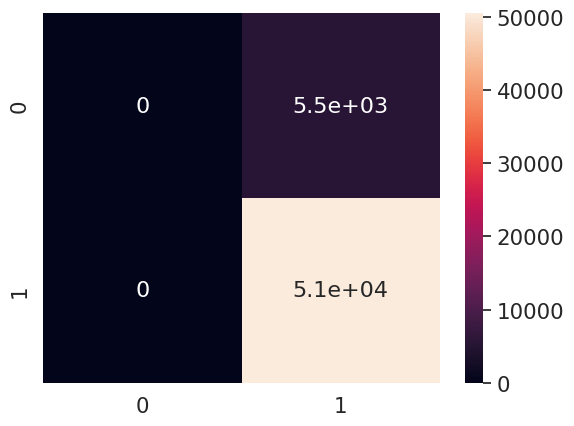

Test precision: 0.9002857142857142
Test recall: 1.0
Test accuracy: 0.9002857142857142


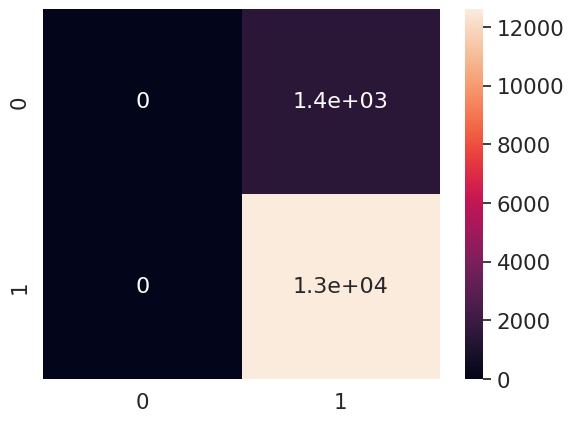

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sn

print(
    "Train precision:",
    precision_score(y_train, y_train_prd, labels=[-1, 1], pos_label=1),
)
print(
    "Train recall:",
    recall_score(y_train, y_train_prd, labels=[-1, 1], pos_label=1),
)
print(
    "Train accuracy:",
    accuracy_score(y_train, y_train_prd),
)

sn.set(font_scale=1.4)
train_conf_mat = confusion_matrix(y_train, y_train_prd, labels=[-1, 1])
sn.heatmap(train_conf_mat, annot=True, annot_kws={"size": 16})
plt.show()

print(
    "Test precision:",
    precision_score(y_test, y_test_prd, labels=[-1, 1], pos_label=1),
)
print(
    "Test recall:",
    recall_score(y_test, y_test_prd, labels=[-1, 1], pos_label=1),
)
print(
    "Test accuracy:",
    accuracy_score(y_test, y_test_prd),
)

test_conf_mat = confusion_matrix(y_test, y_test_prd, labels=[-1, 1])
sn.heatmap(test_conf_mat, annot=True, annot_kws={"size": 16})
plt.show()